# DistilBERT : Training a Text Classifier
![title](distilbert.png)

Feature extraction:: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.

In [20]:
from datasets import load_dataset
import pandas as pd
dataset = load_dataset("cornell-movie-review-data/rotten_tomatoes")

In [2]:
#!pip install transformers

In [3]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt, clean_up_tokenization_spaces=True)

# encoded_text = tokenizer(text)
# tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
# tokenizer.convert_tokens_to_string(tokens)

In [4]:
tokenizer.vocab_size

30522

In [5]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [6]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [7]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [8]:
print(dataset_encoded["train"][0])

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1, 'input_ids': [101, 1996, 2600, 2003, 16036, 2000, 2022, 1996, 7398, 2301, 1005, 1055, 2047, 1000, 16608, 1000, 1998, 2008, 2002, 1005, 1055, 2183, 2000, 2191, 1037, 17624, 2130, 3618, 2084, 7779, 29058, 8625, 13327, 1010, 3744, 1011, 18856, 19513, 3158, 5477, 4168, 2030, 7112, 16562, 2140, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [9]:
from transformers import AutoModel
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [10]:
text = "Best Movie Ever 10/10"
inputs = tokenizer(text, return_tensors="pt")
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.0788, -0.1689,  0.2916,  ..., -0.0933,  0.4203,  0.1773],
         [-0.6960, -0.0190,  0.2176,  ...,  0.2375,  1.0894, -0.4475],
         [ 0.3967, -0.4406, -0.0312,  ..., -0.0781,  0.4020, -0.6944],
         ...,
         [-0.5760, -0.4537,  0.6101,  ...,  0.0918,  0.2275, -0.7492],
         [-0.5405, -0.1984,  0.5382,  ..., -0.0537,  0.2675, -0.9841],
         [ 1.0235,  0.0887, -0.3117,  ...,  0.0952, -0.4204, -0.3583]]]), hidden_states=None, attentions=None)


In [11]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [12]:
dataset_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
})

In [13]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [14]:
import numpy as np

X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((8530, 768), (1066, 768))

In [18]:
# !pip install umap-learn
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [21]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,-1.096291,4.158119,1
1,-0.550615,2.178486,1
2,-1.835138,8.558237,1
3,-3.345352,5.341051,1
4,-1.073200,4.674599,1


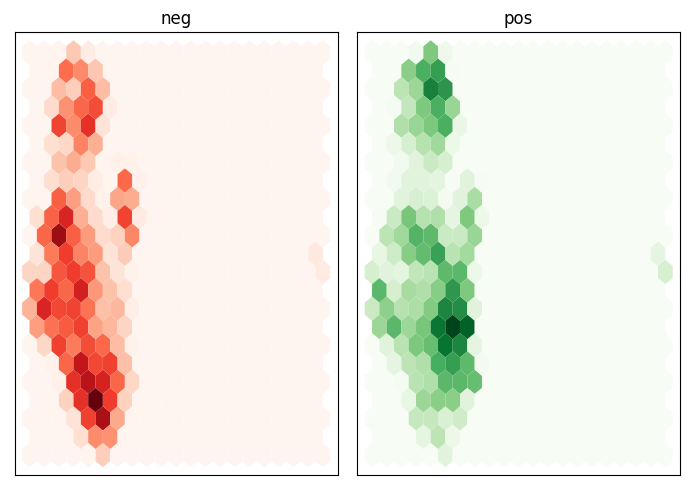

In [25]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(7,5))
axes = axes.flatten()
cmaps = [ "Reds", "Greens"]
labels = dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [30]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [31]:
lr_clf.score(X_valid, y_valid)

0.8292682926829268

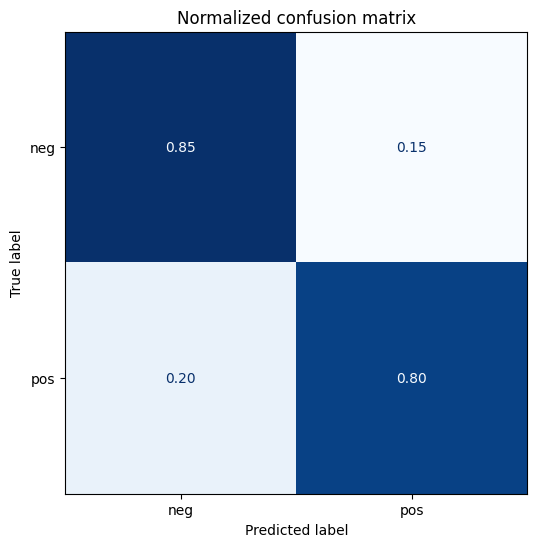

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)